In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

import json

from utils import *
import ast

In [2]:
NUM_SAMPLES_PER_CLASS = 100000
NUM_VAL = 50 * 340

In [3]:
PATH = Path('../data/quickdraw/')

In [4]:
PATH.ls()

[PosixPath('../data/quickdraw/test_simplified.csv'),
 PosixPath('../data/quickdraw/train_simplified.zip'),
 PosixPath('../data/quickdraw/train')]

### data prep

In [5]:
dfs = []
for p in (PATH/"train").ls():
    sample_df = pd.read_csv(p, usecols=[1,3,5])
    print(p.name, sample_df.shape)
    sample_df = sample_df[sample_df.recognized].reset_index(drop=True)[['drawing', 'word']]
    dfs.append(sample_df.sample(min(len(sample_df), NUM_SAMPLES_PER_CLASS)))

wine bottle.csv (126373, 3)
light bulb.csv (120879, 3)
lightning.csv (151560, 3)
raccoon.csv (119588, 3)
ocean.csv (131493, 3)
tent.csv (131527, 3)
helmet.csv (121899, 3)
zebra.csv (144608, 3)
t-shirt.csv (125233, 3)
shovel.csv (117194, 3)
stop sign.csv (119814, 3)
flamingo.csv (124569, 3)
cell phone.csv (121130, 3)
castle.csv (122534, 3)
campfire.csv (133395, 3)
shark.csv (126050, 3)
matches.csv (143969, 3)
saw.csv (121256, 3)
owl.csv (169632, 3)
tooth.csv (125064, 3)
train.csv (127948, 3)
parrot.csv (185530, 3)
carrot.csv (132459, 3)
picture frame.csv (122371, 3)
dragon.csv (124362, 3)
elephant.csv (126969, 3)
swan.csv (152088, 3)
ant.csv (124612, 3)
The Great Wall of China.csv (193015, 3)
dumbbell.csv (157975, 3)
drill.csv (136786, 3)
toothbrush.csv (124828, 3)
blueberry.csv (127878, 3)
animal migration.csv (137847, 3)
see saw.csv (131936, 3)
camera.csv (128772, 3)
finger.csv (167957, 3)
clarinet.csv (126214, 3)
hand.csv (291773, 3)
shorts.csv (124970, 3)
smiley face.csv (124386, 3)

In [6]:
len(dfs)

340

In [7]:
dfs_combined = pd.concat(dfs, axis=0)

In [8]:
dfs_combined.reset_index(drop=True, inplace=True)

In [9]:
dfs_combined.to_csv(PATH/"train/dfs_combined.csv")

###  Create ImageDataBunch using the data block API

In [5]:
bs = 256
sz = 256

In [6]:
dfs_combined = pd.read_csv(PATH/"train/dfs_combined.csv")

In [7]:
test_df = pd.read_csv(PATH/"test_simplified.csv")

In [23]:
dfs_combined = dfs_combined[['drawing', 'word']]

In [24]:
def create_func(item):
    arr = list2drawing(ast.literal_eval(item[0]), size=sz, lw=6, time_color=True)
    img = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    tensor = torch.from_numpy(img).float()
    return Image(tensor.permute((2,0,1)).div_(255))

In [25]:
item_list = ItemList.from_df(dfs_combined, cols=['drawing', 'word'], create_func=create_func)

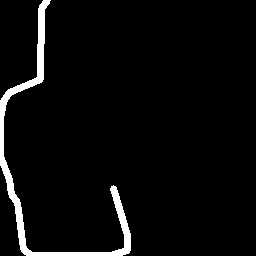

In [26]:
item_list[0]

In [27]:
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]
item_lists = item_list.split_by_idx(val_idxs)

In [28]:
label_lists = item_lists.label_from_df(cols=1)

In [29]:
label_lists.train.y

CategoryList (33959415 items)
[Category wine bottle, Category wine bottle, Category wine bottle, Category wine bottle, Category wine bottle]...
Path: .

In [30]:
label_lists.valid.y

CategoryList (17000 items)
[Category skyscraper, Category sea turtle, Category violin, Category clock, Category bear]...
Path: .

In [31]:
item_lists.train[0]

(Image (3, 256, 256), Category wine bottle)

In [32]:
test_items = ItemList.from_df(test_df, cols=['drawing', 'key_id'], create_func=create_func)

In [33]:
label_lists.add_test(test_items);

In [34]:
train_dl = DataLoader(label_lists.train, bs, True, num_workers=8)
valid_dl = DataLoader(label_lists.valid, bs, False, num_workers=8)
test_dl = DataLoader(label_lists.test, bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

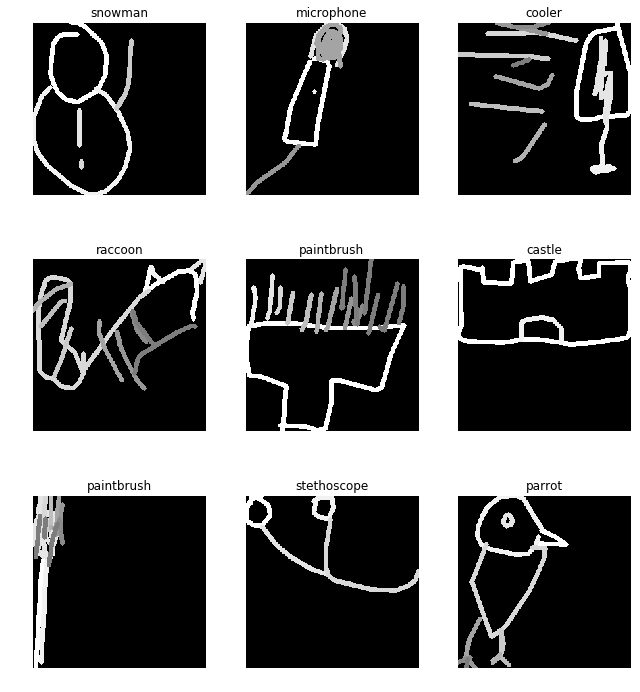

In [35]:
data_bunch.show_batch(3)

### Train

In [36]:
name = f'res34-{sz}'

In [37]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])

In [ ]:
learn.fit_one_cycle(1, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,map3


In [ ]:
learn.save(f'{name}-stage-1')

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(6, max_lr=6e-4)

Total time: 24:25
epoch  train_loss  valid_loss  accuracy  map3    
1      1.448672    1.383536    0.658706  0.739206  (04:04)
2      1.358841    1.285606    0.681059  0.757471  (04:04)
3      1.165717    1.180751    0.707647  0.780500  (04:04)
4      0.927250    1.081052    0.732294  0.800314  (04:03)
5      0.639683    1.044819    0.744294  0.810804  (04:03)
6      0.454999    1.067124    0.744647  0.810461  (04:03)



In [26]:
learn.save(f'{name}-stage-2')

### Predict

In [27]:
learn.load(f'{name}-stage-2');

In [28]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [31]:
create_submission(preds, data_bunch.test_dl, name)

In [32]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9221337500464606,sock shoe foot
1,9950013608613660,leaf feather stitches
2,9005540600650567,broom paintbrush rake
3,9031090525591545,chair giraffe toilet
4,9896706467105420,flamingo swan bird


In [33]:
# !kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

100%|██████████████████████████████████████| 1.52M/1.52M [00:17<00:00, 93.0kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge